In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

import joblib 

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
import json


In [2]:
# Initialize Porter Stemmer
ps = PorterStemmer()

# Load stopwords
with open('../../Datasets/stopwords-tl.json', 'r') as f:
    stopwords = json.load(f)

# Custom transformer for text preprocessing
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [' '.join(self.preprocess(text)) for text in X]
    
    def preprocess(self, text):
        tokens = nltk.word_tokenize(text)
        stems = [ps.stem(token) for token in tokens]
        filtered = [stem for stem in stems if stem not in stopwords]
        return filtered

In [3]:
stack = joblib.load('../../Models/70-30 Test/pipeline_lr.joblib')

training = pd.read_csv('../../Data Splits/test_data.csv')

training_x = training['article']

training_y = training['label']



Metrics for MNB:
Accuracy: 0.8604651162790697
Precision: 0.7978142076502732
Recall: 0.9668874172185431
F1 Score: 0.874251497005988
AUC: 0.9558498896247241
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.75      0.84       150
           1       0.80      0.97      0.87       151

    accuracy                           0.86       301
   macro avg       0.88      0.86      0.86       301
weighted avg       0.88      0.86      0.86       301



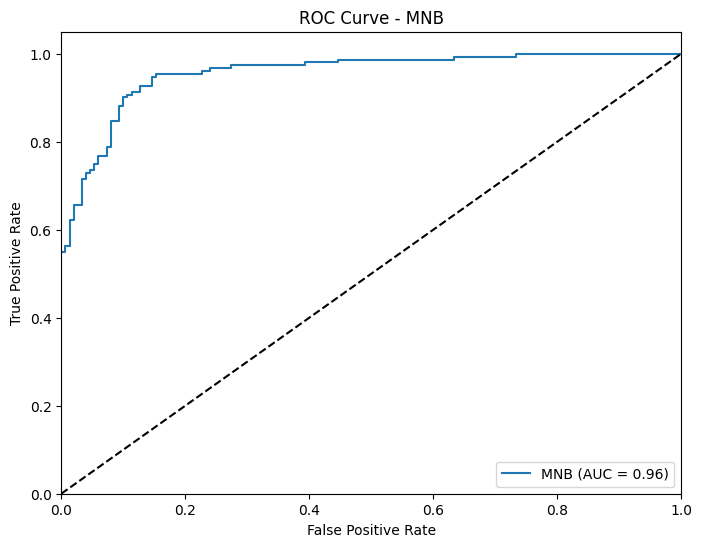

Metrics for LR:
Accuracy: 0.867109634551495
Precision: 0.9586776859504132
Recall: 0.7682119205298014
F1 Score: 0.8529411764705882
AUC: 0.9674613686534217
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88       150
           1       0.96      0.77      0.85       151

    accuracy                           0.87       301
   macro avg       0.88      0.87      0.87       301
weighted avg       0.88      0.87      0.87       301



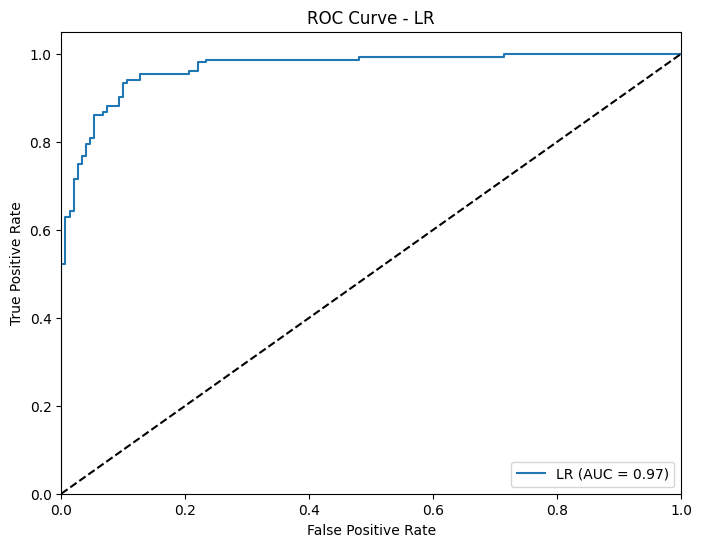

Metrics for RF:
Accuracy: 0.8870431893687708
Precision: 0.9534883720930233
Recall: 0.8145695364238411
F1 Score: 0.8785714285714286
AUC: 0.9710375275938189
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.89       150
           1       0.95      0.81      0.88       151

    accuracy                           0.89       301
   macro avg       0.90      0.89      0.89       301
weighted avg       0.90      0.89      0.89       301



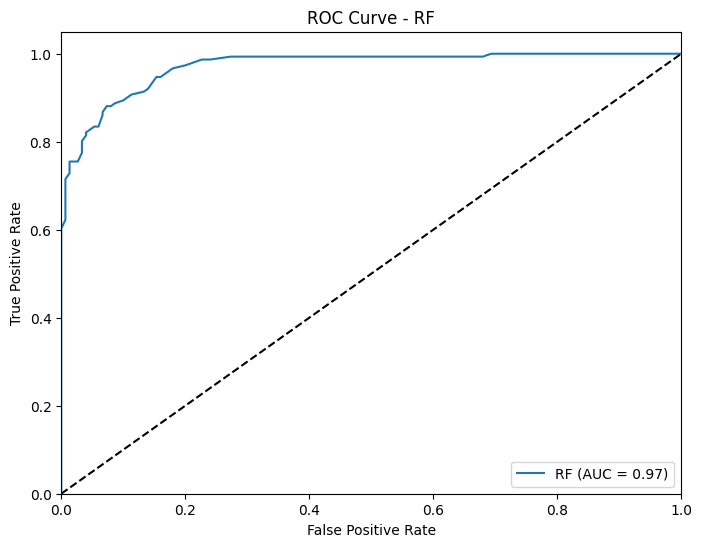

Metrics for KNN:
Accuracy: 0.8338870431893688
Precision: 0.8023952095808383
Recall: 0.8874172185430463
F1 Score: 0.8427672955974843
AUC: 0.9228697571743929
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.78      0.82       150
           1       0.80      0.89      0.84       151

    accuracy                           0.83       301
   macro avg       0.84      0.83      0.83       301
weighted avg       0.84      0.83      0.83       301



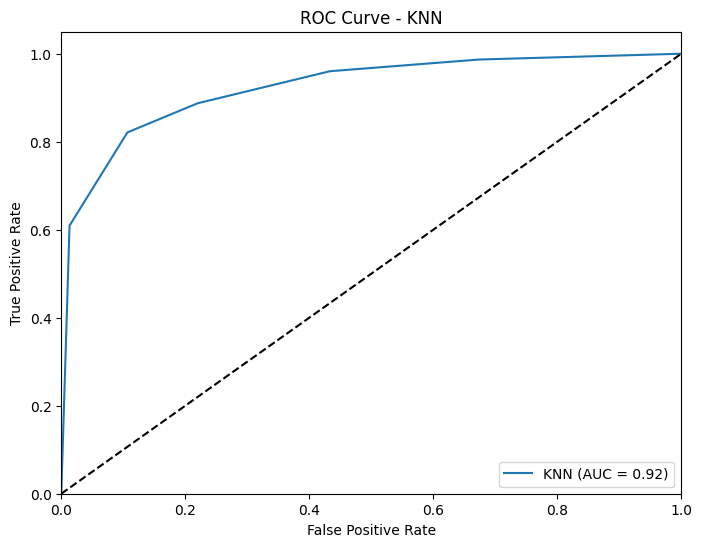

Metrics for SVM:
Accuracy: 0.8770764119601329
Precision: 0.975
Recall: 0.7748344370860927
F1 Score: 0.8634686346863468
AUC: 0.9739514348785874
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89       150
           1       0.97      0.77      0.86       151

    accuracy                           0.88       301
   macro avg       0.89      0.88      0.88       301
weighted avg       0.89      0.88      0.88       301



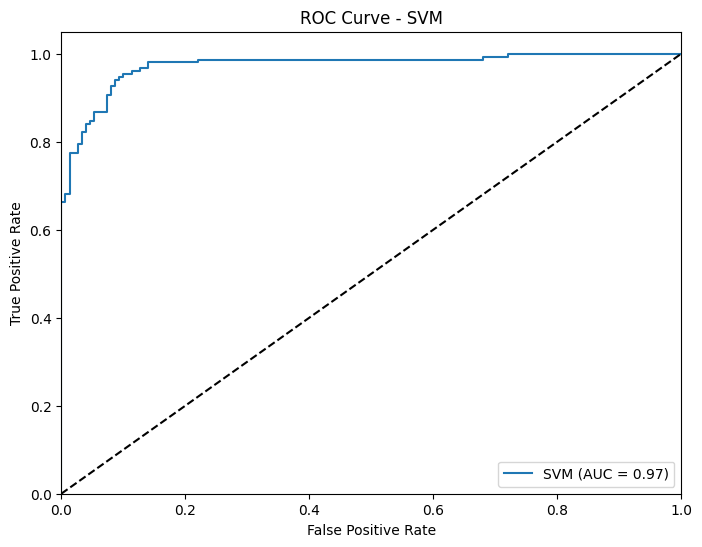

Metrics for Stacking Model:
Accuracy: 0.9435215946843853
Precision: 0.935064935064935
Recall: 0.9536423841059603
F1 Score: 0.9442622950819672
AUC: 0.9839293598233995
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       150
           1       0.94      0.95      0.94       151

    accuracy                           0.94       301
   macro avg       0.94      0.94      0.94       301
weighted avg       0.94      0.94      0.94       301



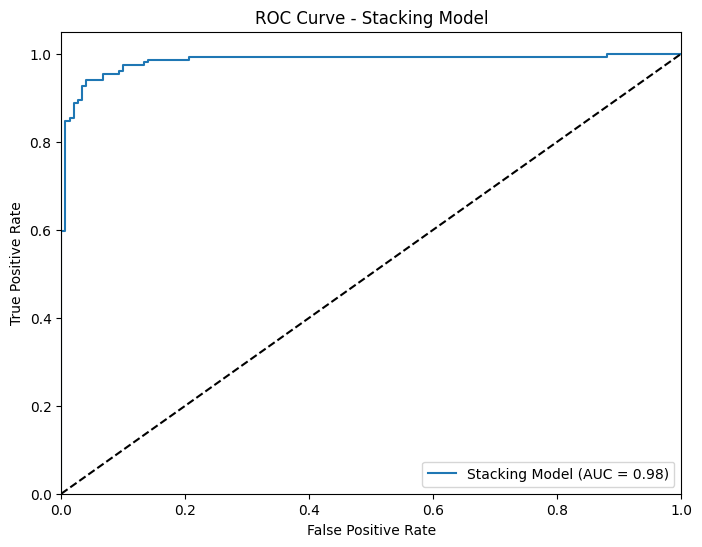

Comparison of Models:
                Accuracy Precision    Recall  F1 Score       AUC
MNB             0.860465  0.797814  0.966887  0.874251   0.95585
LR               0.86711  0.958678  0.768212  0.852941  0.967461
RF              0.887043  0.953488   0.81457  0.878571  0.971038
KNN             0.833887  0.802395  0.887417  0.842767   0.92287
SVM             0.877076     0.975  0.774834  0.863469  0.973951
Stacking Model  0.943522  0.935065  0.953642  0.944262  0.983929


In [4]:
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']
metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

vectorized_text = stack.named_steps['vectorizer'].transform(training_x)

# Evaluate base models
for model, name in  zip(stack.named_steps['stacking'].estimators_ , base_names):
    y_pred = model.predict(vectorized_text)
    y_prob = model.predict_proba(vectorized_text)[:, 1]  # Probability for positive class for ROC curve
    
    accuracy = accuracy_score(training_y, y_pred)
    precision = precision_score(training_y, y_pred)
    recall = recall_score(training_y, y_pred)
    f1 = f1_score(training_y, y_pred)
    auc = roc_auc_score(training_y, y_prob)

    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")
    print(f"Classification Report:\n{classification_report(training_y, y_pred)}")

    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

    # ROC Curve
    fpr, tpr, _ = roc_curve(training_y, y_prob)
    roc_auc = roc_auc_score(training_y, y_prob)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()


# Evaluate stacking model
stack_y_pred = stack.predict(training_x)
stack_y_prob = stack.predict_proba(training_x)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy = accuracy_score(training_y, stack_y_pred)
stack_precision = precision_score(training_y, stack_y_pred)
stack_recall = recall_score(training_y, stack_y_pred)
stack_f1 = f1_score(training_y, stack_y_pred)
stack_auc = roc_auc_score(training_y, stack_y_prob)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy}")
print(f"Precision: {stack_precision}")
print(f"Recall: {stack_recall}")
print(f"F1 Score: {stack_f1}")
print(f"AUC: {stack_auc}")
print(f"Classification Report:\n{classification_report(training_y, stack_y_pred)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(training_y, stack_y_prob)
stack_roc_auc = roc_auc_score(training_y, stack_y_prob)

# Store stacking model metrics in the DataFrame
metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'Stacking Model (AUC = {stack_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

# Display the comparison table
print("Comparison of Models:")
print(metrics_df)

In [6]:
best_meta = joblib.load('../../Models/70-30 Test/pipeline_lr_best_estimator.joblib')
print(best_meta)

best_meta2 = joblib.load('../../Models/70-30 Test/pipeline_xgb_best_estimator.joblib')




LogisticRegression(C=1000, solver='liblinear')
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
